# Análisis VBox

Importación de librerías:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import numpy as np
import warnings
from ipywidgets import interact, FloatRangeSlider
from matplotlib.widgets import RectangleSelector
from ipywidgets import interactive
import ipywidgets as widgets
from IPython.display import display

Cargar datos necesarios:

In [2]:
file_path = "20240808. Plantilla Data TK419 8-ago-24.csv"
df = pd.read_csv(file_path, encoding="latin1")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158410 entries, 0 to 158409
Data columns (total 30 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   UTC time                         158410 non-null  float64
 1   Satellites                       158410 non-null  int64  
 2   Speed (km/h)                     158410 non-null  float64
 3   Heading (Degrees)                158410 non-null  float64
 4   Latitude                         158410 non-null  object 
 5   Longitude                        158410 non-null  object 
 6   BrakeTrigger                     158410 non-null  int64  
 7   Dgps                             158410 non-null  int64  
 8   Wav file                         158410 non-null  int64  
 9   Dual antenna                     158410 non-null  int64  
 10  Height (m)                       158410 non-null  float64
 11  Vertical velocity (km/h)         158410 non-null  float64
 12  Lo

UTC time  Satellites  Speed (km/h)  Heading (Degrees)        Latitude  \
0  171136.4           4          3.93              290.1  18°56.877760 N   
1  171137.4           4          0.00              256.6  18°56.880640 N   
2  171138.4           4          1.82              302.9  18°56.880880 N   
3  171139.4           4          2.08              319.2  18°56.880310 N   
4  171140.4           4          2.98              319.0  18°56.878910 N   

        Longitude  BrakeTrigger  Dgps  Wav file  Dual antenna  ...  Day  \
0  70°10.315430 W             0     0         0             0  ...  NaN   
1  70°10.318830 W             0     0         0             0  ...  NaN   
2  70°10.319190 W             0     0         0             0  ...  NaN   
3  70°10.318610 W             0     0         0             0  ...  NaN   
4  70°10.317810 W             0     0         0             0  ...  NaN   

   Relative height (m)  Radius of turn (m)  MovingAvgFront  MovingAvgRear  \
0            -31833.80                2.68        0.000000       0.000000   
1            -31833.40                0.00        0.000000       0.000000   
2            -31833.52                1.52        0.000000       0.000000   
3            -31834.05                3.41        0.022259       0.022596   
4            -31834.60                2.28        0.000000       0.000000   

   TxPhF  TxPhR  VehicleWeight (tonnes)  Latitude.1  Longitude.1  
0     56     56                     140   18.947963   -70.171924  
1     56     56                     140   18.948011   -70.171981  
2     56     56                     140   18.948015   -70.171987  
3     56     56                     140   18.948005   -70.171977  
4     56     56                     140   18.947982   -70.171964  

[5 rows x 30 columns]

Conversión de variables:

In [3]:
# Función para convertir coordenadas en formato grados, minutos a decimal
def dms_to_decimal(coord):
    try:
        parts = coord.strip().split("°")
        degrees = float(parts[0])
        minutes = float(parts[1].split(" ")[0]) / 60
        direction = parts[1].split(" ")[1]
        decimal_coord = degrees + minutes
        if direction in ["S", "W"]:
            decimal_coord *= -1
        return decimal_coord
    except:
        return None

# Convertir latitud y longitud
df["Latitude"] = df["Latitude"].apply(dms_to_decimal)
df["Longitude"] = df["Longitude"].apply(dms_to_decimal)

# Convertir UTC time a timestamp
df["UTC time"] = pd.to_numeric(df["UTC time"], errors="coerce")
df["Time (seconds)"] = df["UTC time"] % 100
df["Time (minutes)"] = (df["UTC time"] // 100) % 100
df["Time (hours)"] = df["UTC time"] // 10000
df["Timestamp"] = pd.to_datetime(df["Time (hours)"].astype(int).astype(str) + ":" +
                                 df["Time (minutes)"].astype(int).astype(str) + ":" +
                                 df["Time (seconds)"].astype(int).astype(str), 
                                 format="%H:%M:%S", errors="coerce")
df.head()

UTC time  Satellites  Speed (km/h)  Heading (Degrees)   Latitude  \
0  171136.4           4          3.93              290.1  18.947963   
1  171137.4           4          0.00              256.6  18.948011   
2  171138.4           4          1.82              302.9  18.948015   
3  171139.4           4          2.08              319.2  18.948005   
4  171140.4           4          2.98              319.0  18.947982   

   Longitude  BrakeTrigger  Dgps  Wav file  Dual antenna  ...  MovingAvgRear  \
0 -70.171924             0     0         0             0  ...       0.000000   
1 -70.171981             0     0         0             0  ...       0.000000   
2 -70.171987             0     0         0             0  ...       0.000000   
3 -70.171977             0     0         0             0  ...       0.022596   
4 -70.171964             0     0         0             0  ...       0.000000   

   TxPhF  TxPhR  VehicleWeight (tonnes)  Latitude.1  Longitude.1  \
0     56     56                     140   18.947963   -70.171924   
1     56     56                     140   18.948011   -70.171981   
2     56     56                     140   18.948015   -70.171987   
3     56     56                     140   18.948005   -70.171977   
4     56     56                     140   18.947982   -70.171964   

   Time (seconds)  Time (minutes)  Time (hours)           Timestamp  
0            36.4            11.0          17.0 1900-01-01 17:11:36  
1            37.4            11.0          17.0 1900-01-01 17:11:37  
2            38.4            11.0          17.0 1900-01-01 17:11:38  
3            39.4            11.0          17.0 1900-01-01 17:11:39  
4            40.4            11.0          17.0 1900-01-01 17:11:40  

[5 rows x 34 columns]

Análisis estadístico de variables:

In [4]:
df.describe()

UTC time     Satellites   Speed (km/h)  Heading (Degrees)  \
count  158410.000000  158410.000000  158410.000000      158410.000000   
mean   115084.056486       6.771208       9.861244         184.400155   
min         0.900000       4.000000       0.000000           0.000000   
25%     53014.950000       6.000000       0.000000          93.900000   
50%    110020.350000       7.000000       1.840000         182.100000   
75%    182952.400000       7.000000      14.500000         279.700000   
max    235959.900000       8.000000     171.550000         360.000000   
std     71515.939710       0.852974      13.700746         105.169663   

            Latitude      Longitude  BrakeTrigger      Dgps  Wav file  \
count  158410.000000  158410.000000      158410.0  158410.0  158410.0   
mean       18.937447     -70.178886           0.0       0.0       0.0   
min        18.906577     -70.195912           0.0       0.0       0.0   
25%        18.933342     -70.182980           0.0       0.0       0.0   
50%        18.941344     -70.179028           0.0       0.0       0.0   
75%        18.946003     -70.172178           0.0       0.0       0.0   
max        18.957881     -70.165875           0.0       0.0       0.0   
std         0.011920       0.007603           0.0       0.0       0.0   

       Dual antenna  ...  MovingAvgRear          TxPhF          TxPhR  \
count      158410.0  ...  158410.000000  158410.000000  158410.000000   
mean            0.0  ...       8.695991     393.171965     342.911817   
min             0.0  ...       0.000000       0.000000       0.000000   
25%             0.0  ...       0.000000     158.000000     154.000000   
50%             0.0  ...       0.000000     302.000000     293.000000   
75%             0.0  ...       0.000000     612.000000     570.000000   
max             0.0  ...    1008.161302     894.000000     755.000000   
std             0.0  ...      74.697261     280.837637     238.835602   

       VehicleWeight (tonnes)     Latitude.1    Longitude.1  Time (seconds)  \
count                158410.0  158410.000000  158410.000000   158410.000000   
mean                    140.0      18.937447     -70.178886       29.909020   
min                     140.0      18.906577     -70.195912        0.000000   
25%                     140.0      18.933342     -70.182980       15.000000   
50%                     140.0      18.941344     -70.179028       30.000000   
75%                     140.0      18.946003     -70.172178       45.000000   
max                     140.0      18.957881     -70.165875       59.900000   
std                       0.0       0.011920       0.007603       17.319471   

       Time (minutes)   Time (hours)                      Timestamp  
count   158410.000000  158410.000000                         158410  
mean        29.497349      11.210441  1900-01-01 11:42:36.931758848  
min          0.000000       0.000000            1900-01-01 00:00:00  
25%         14.000000       5.000000  1900-01-01 05:30:14.249999872  
50%         29.000000      11.000000            1900-01-01 11:00:20  
75%         45.000000      18.000000            1900-01-01 18:29:52  
max         59.000000      23.000000            1900-01-01 23:59:59  
std         17.319458       7.148891                            NaN  

[8 rows x 34 columns]

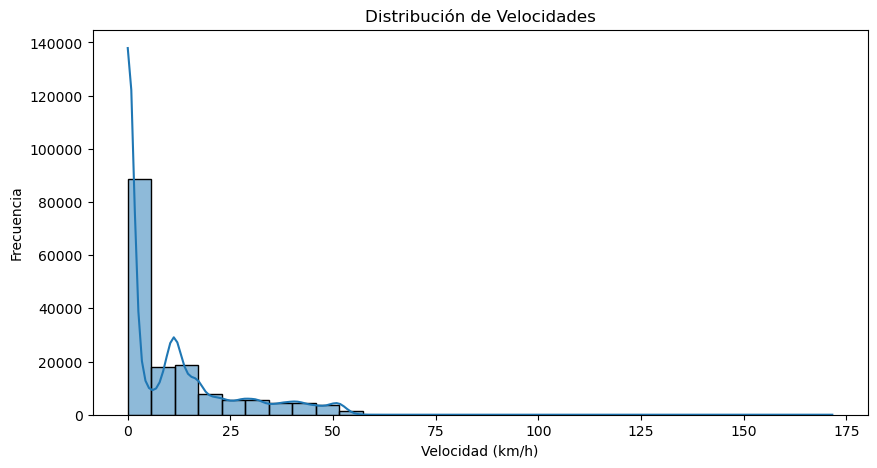

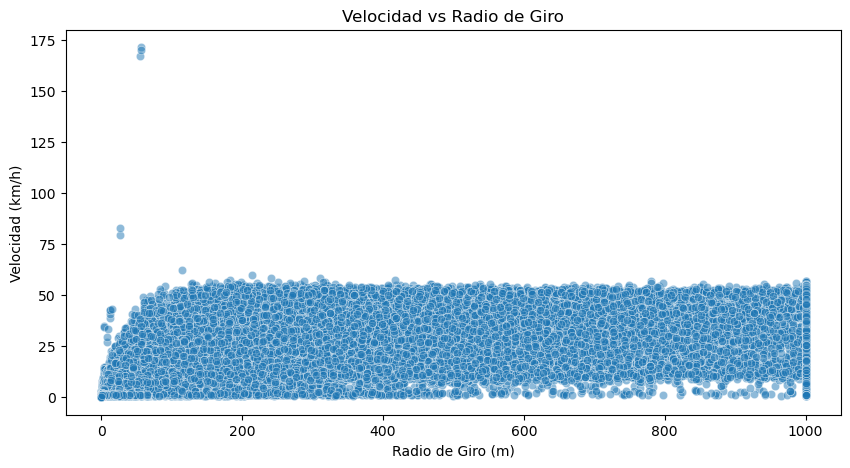

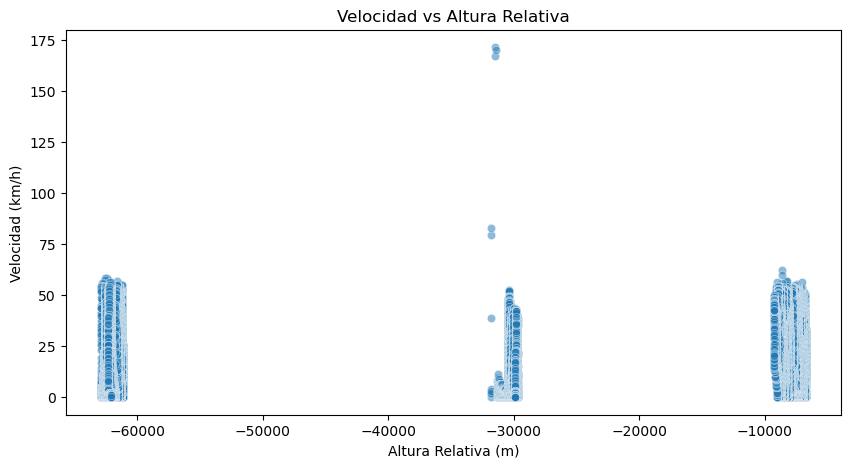

In [11]:
# Análisis exploratorio
plt.figure(figsize=(10, 5))
sns.histplot(df["Speed (km/h)"], bins=30, kde=True)
plt.title("Distribución de Velocidades")
plt.xlabel("Velocidad (km/h)")
plt.ylabel("Frecuencia")
plt.show()

# Relación entre velocidad y radio de giro
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df["Radius of turn (m)"], y=df["Speed (km/h)"], alpha=0.5)
plt.title("Velocidad vs Radio de Giro")
plt.xlabel("Radio de Giro (m)")
plt.ylabel("Velocidad (km/h)")
plt.show()

# Relación entre altura relativa y velocidad
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df["Relative height (m)"], y=df["Speed (km/h)"], alpha=0.5)
plt.title("Velocidad vs Altura Relativa")
plt.xlabel("Altura Relativa (m)")
plt.ylabel("Velocidad (km/h)")
plt.show()


mapa = folium.Map(
    location=[df["Latitude"].mean(), df["Longitude"].mean()], 
    zoom_start=12, 
    tiles="Esri WorldImagery"  # Fondo de imagen satelital con relieve
)

# ----------------------------------------------------------------
# -------------------- PRUEBA MAPA CON PUNTOS --------------------
# ----------------------------------------------------------------

# # Agregar puntos individuales al mapa
# for _, row in df.dropna(subset=["Latitude", "Longitude"]).iterrows():
#     folium.CircleMarker(
#         location=[row["Latitude"], row["Longitude"]],
#         radius=1,  # Tamaño del punto
#         color="red",  # Color del borde
#         fill=True,
#         fill_color="red",  # Color del interior
#         fill_opacity=0.2
#     ).add_to(mapa)

# # Mostrar el mapa
# mapa

# ----------------------------------------------------------------
# --------------------------HEATMAP-------------------------------
# ----------------------------------------------------------------
mapa = folium.Map(
    location=[df["Latitude"].mean(), df["Longitude"].mean()], 
    zoom_start=12, 
    tiles="Esri WorldImagery"  # Opción de relieve
)

HeatMap(df[["Latitude", "Longitude"]].dropna()).add_to(mapa)
mapa

# "Stamen Terrain" → Muestra elevaciones con sombreado.
# "Esri WorldImagery" → Imagen satelital con relieve visible.
# "OpenTopoMap" → Mapa topográfico con curvas de nivel.

Análisis de puntos críticos:

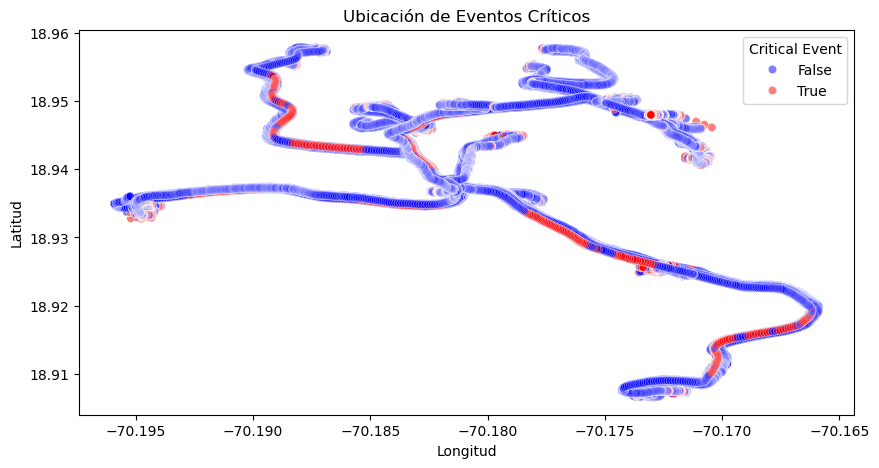

In [ ]:
# Identificación de eventos críticos
df["Sharp Turn"] = df["Radius of turn (m)"].apply(lambda x: x < 5)  # Giro pronunciado menor a 5 m
df["High Speed"] = df["Speed (km/h)"].apply(lambda x: x > 50)  # Velocidad superior a 50 km/h
df["Critical Event"] = df[["Sharp Turn", "High Speed"]].any(axis=1)

# Visualización de eventos críticos
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df["Longitude"], y=df["Latitude"], hue=df["Critical Event"], palette={True: "red", False: "blue"}, alpha=0.5)
plt.title("Ubicación de Eventos Críticos")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()


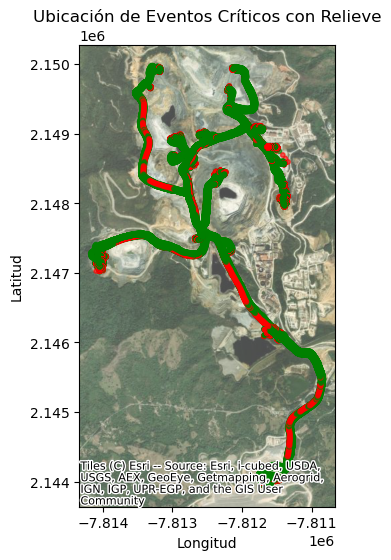

In [ ]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

# Convertir DataFrame a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["Longitude"], df["Latitude"]), crs="EPSG:4326")

# Convertir a coordenadas Web Mercator para mapas base
gdf = gdf.to_crs(epsg=3857)

# Asignar colores manualmente
gdf["color"] = gdf["Critical Event"].map({True: "red", False: "green"})

# Crear figura
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar puntos con los colores asignados
gdf.plot(ax=ax, color=gdf["color"], markersize=10, alpha=0.6)

# Agregar mapa base con relieve (Usar OpenTopoMap o Esri)
ctx.add_basemap(ax, source=ctx.providers.Esri.  WorldImagery, alpha=0.7)

# Ajustar etiquetas
ax.set_title("Ubicación de Eventos Críticos con Relieve")
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")

plt.show()


### Análisis de clustering (Zonas con Altas densidades):

In [7]:
# Aplicación de clustering K-Means para identificar zonas de alta densidad
coords = df[df["Critical Event"]][["Latitude", "Longitude"]].dropna().values
if len(coords) > 0:
    n_clusters = min(10, len(coords))  # Determinar un número razonable de clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10).fit(coords)
    df.loc[df["Critical Event"], "Cluster"] = kmeans.labels_
else:
    df["Cluster"] = -1


c:\Users\jacosta\AppData\Local\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\jacosta\AppData\Local\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\jacosta\AppData\Local\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jacosta\AppData\Local\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\jacosta\AppData\Local\anacond

Visualizacion de clustering y puntos criticos

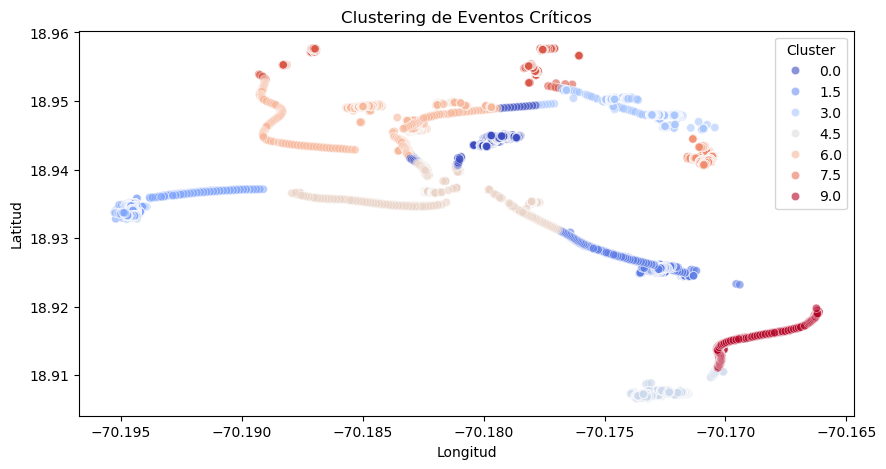

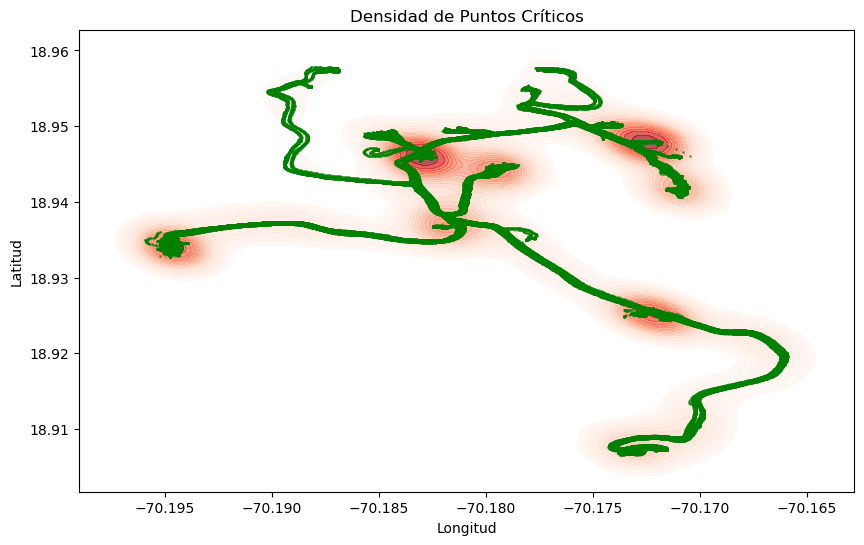

In [8]:
# Visualización de clustering
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df["Longitude"], y=df["Latitude"], hue=df["Cluster"], palette="coolwarm", alpha=0.6)
plt.title("Clustering de Eventos Críticos")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.legend(title="Cluster")
plt.show()

# Gráfico de densidad bivariada de eventos críticos
plt.figure(figsize=(10, 6))
sns.kdeplot(x=df["Longitude"], y=df["Latitude"], fill=True, cmap="Reds", levels=20, alpha=0.7)
plt.scatter(df["Longitude"], df["Latitude"], s=1, color="green", alpha=0.5)
plt.title("Densidad de Puntos Críticos")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()



Indicador de criticidad:

In [9]:
# Función para calcular criticidad
def calcular_criticidad(lat_range, lon_range):
    subset = df[(df["Latitude"] >= lat_range[0]) & (df["Latitude"] <= lat_range[1]) &
                (df["Longitude"] >= lon_range[0]) & (df["Longitude"] <= lon_range[1]) &
                (df["Critical Event"] == True)]
    return len(subset)

# Función para actualizar la gráfica interactiva
def actualizar_grafico(lat_range, lon_range):
    criticidad = calcular_criticidad(lat_range, lon_range)
    plt.figure(figsize=(10, 6))
    sns.kdeplot(x=df["Longitude"], y=df["Latitude"], fill=True, cmap="Reds", levels=20, alpha=0.7)
    plt.scatter(df["Longitude"], df["Latitude"], s=1, color="black", alpha=0.5)
    plt.xlim(lon_range)
    plt.ylim(lat_range)
    plt.title(f"Densidad de Puntos Críticos (Criticidad: {criticidad})")
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.show()

# Crear sliders interactivos
lat_slider = FloatRangeSlider(
    value=[df["Latitude"].min(), df["Latitude"].max()],
    min=df["Latitude"].min(), max=df["Latitude"].max(), step=0.0005,
    description='Latitud')

lon_slider = FloatRangeSlider(
    value=[df["Longitude"].min(), df["Longitude"].max()],
    min=df["Longitude"].min(), max=df["Longitude"].max(), step=0.0005,
    description='Longitud')

interactive_plot = interactive(actualizar_grafico,
                               lat_range=lat_slider,
                               lon_range=lon_slider)
display(interactive_plot)

interactive(children=(FloatRangeSlider(value=(18.906577166666665, 18.957880833333334), description='Latitud', …

In [ ]:
# import dash
# from dash import dcc, html
# from dash.dependencies import Input, Output
# import pandas as pd
# import plotly.express as px
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
# import io
# import base64
# # Inicializar la app Dash
# app = dash.Dash(__name__)

# app.layout = html.Div([
#     html.H1("Densidad de Puntos Críticos"),
    
#     # Mapa interactivo
#     dcc.Graph(id="mapa", config={"scrollZoom": True}),
    
#     # Slider de criticidad
#     html.Label("Criticidad calculada:"),
#     html.Div(id="criticidad-output"),
    
#     # Imagen de densidad bivariada
#     html.Img(id="densidad-bivariada")
# ])

# @app.callback(
#     [Output("mapa", "figure"), Output("criticidad-output", "children"), Output("densidad-bivariada", "src")],
#     [Input("mapa", "relayoutData")]
# )
# def actualizar_mapa(relayoutData):
#     # Extraer los límites actuales del zoom
#     if relayoutData and "mapbox._derived" in relayoutData:
#         bounds = relayoutData["mapbox._derived"]
#         lat_min, lat_max = bounds["coordinates"][1][1], bounds["coordinates"][0][1]
#         lon_min, lon_max = bounds["coordinates"][0][0], bounds["coordinates"][1][0]
#     else:
#         lat_min, lat_max = df["Latitude"].min(), df["Latitude"].max()
#         lon_min, lon_max = df["Longitude"].min(), df["Longitude"].max()

#     # Filtrar datos en la zona seleccionada
#     df_filtrado = df[(df["Latitude"] >= lat_min) & (df["Latitude"] <= lat_max) &
#                      (df["Longitude"] >= lon_min) & (df["Longitude"] <= lon_max)]
    
#     # Calcular criticidad (ejemplo: cantidad de puntos en la zona)
#     criticidad = len(df_filtrado)

#     # Crear figura del mapa interactivo
#     fig = px.scatter_mapbox(df, lat="Latitude", lon="Longitude",
#                             zoom=10, center={"lat": df["Latitude"].mean(), "lon": df["Longitude"].mean()},
#                             mapbox_style="carto-positron")
    
#     # Generar densidad bivariada
#     fig_densidad, ax = plt.subplots(figsize=(6, 4))
#     sns.kdeplot(x=df["Longitude"], y=df["Latitude"], fill=True, cmap="Reds", levels=20, alpha=0.7, ax=ax)
#     ax.scatter(df["Longitude"], df["Latitude"], s=1, color="black", alpha=0.5)
#     ax.set_xlim([lon_min, lon_max])
#     ax.set_ylim([lat_min, lat_max])
#     ax.set_title("Densidad de Puntos Críticos")
#     ax.set_xlabel("Longitud")
#     ax.set_ylabel("Latitud")
    
#     # Convertir la imagen a base64
#     buf = io.BytesIO()
#     fig_densidad.savefig(buf, format="png")
#     buf.seek(0)
#     encoded_image = base64.b64encode(buf.read()).decode("utf-8")
#     src_image = f"data:image/png;base64,{encoded_image}"
    
#     return fig, f"{criticidad} puntos críticos en la zona", src_image

# # Ejecutar la app
# if __name__ == "__main__":
#     app.run_server(debug=True)



In [11]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import folium
# from folium.plugins import HeatMap
# from sklearn.cluster import KMeans
# import numpy as np
# import plotly.express as px
# import plotly.graph_objects as go
# from dash import Dash, dcc, html, Input, Output, State, dash_table
# import dash
# import os

# # Inicialización de la aplicación Dash
# app = Dash(__name__)

# # Cargar múltiples archivos CSV
# def cargar_archivos(ruta_carpeta):
#     archivos = [f for f in os.listdir(ruta_carpeta) if f.endswith('.csv')]
#     dataframes = {archivo: pd.read_csv(os.path.join(ruta_carpeta, archivo), encoding="latin1") for archivo in archivos}
#     return dataframes

# # Convertir coordenadas en formato grados, minutos a decimal
# def dms_to_decimal(coord):
#     try:
#         parts = coord.strip().split("°")
#         degrees = float(parts[0])
#         minutes = float(parts[1].split(" ")[0]) / 60
#         direction = parts[1].split(" ")[1]
#         decimal_coord = degrees + minutes
#         if direction in ["S", "W"]:
#             decimal_coord *= -1
#         return decimal_coord
#     except:
#         return None

# # Preprocesamiento de datos
# def preprocesar_datos(df):
#     df["Latitude"] = df["Latitude"].apply(dms_to_decimal)
#     df["Longitude"] = df["Longitude"].apply(dms_to_decimal)
#     df["UTC time"] = pd.to_numeric(df["UTC time"], errors="coerce")
#     df["Time (seconds)"] = df["UTC time"] % 100
#     df["Time (minutes)"] = (df["UTC time"] // 100) % 100
#     df["Time (hours)"] = df["UTC time"] // 10000
#     df["Timestamp"] = pd.to_datetime(df["Time (hours)"].astype(int).astype(str) + ":" +
#                                      df["Time (minutes)"].astype(int).astype(str) + ":" +
#                                      df["Time (seconds)"].astype(int).astype(str), 
#                                      format="%H:%M:%S", errors="coerce")
#     df["Sharp Turn"] = df["Radius of turn (m)"].apply(lambda x: x < 5)
#     df["High Speed"] = df["Speed (km/h)"].apply(lambda x: x > 50)
#     df["Critical Event"] = df[["Sharp Turn", "High Speed"]].any(axis=1)
#     return df

# # Calcular criticidad
# def calcular_criticidad(df, lat_range, lon_range):
#     subset = df[(df["Latitude"] >= lat_range[0]) & (df["Latitude"] <= lat_range[1]) &
#                 (df["Longitude"] >= lon_range[0]) & (df["Longitude"] <= lon_range[1]) &
#                 (df["Critical Event"] == True)]
#     return len(subset)

# # Layout de la aplicación
# app.layout = html.Div([
#     html.H1("Análisis de Criticidad de Zonas"),
#     dcc.Upload(
#         id='upload-data',
#         children=html.Div(['Arrastra y suelta o ', html.A('selecciona archivos')]),
#         style={
#             'width': '100%', 'height': '60px', 'lineHeight': '60px',
#             'borderWidth': '1px', 'borderStyle': 'dashed',
#             'borderRadius': '5px', 'textAlign': 'center', 'margin': '10px'
#         },
#         multiple=True
#     ),
#     dcc.Graph(id='map-graph'),
#     html.Div(id='criticidad-output')
# ])

# # Callbacks para actualizar el gráfico y calcular criticidad
# @app.callback(
#     Output('map-graph', 'figure'),
#     Output('criticidad-output', 'children'),
#     Input('upload-data', 'contents'),
#     State('upload-data', 'filename')
# )
# def actualizar_grafico(contents, filenames):
#     if contents:
#         dataframes = {name: pd.read_csv(name, encoding="latin1") for name in filenames}
#         criticidad_dict = {}

#         fig = go.Figure()

#         for name, df in dataframes.items():
#             df = preprocesar_datos(df)
#             criticidad = calcular_criticidad(df, [df["Latitude"].min(), df["Latitude"].max()], [df["Longitude"].min(), df["Longitude"].max()])
#             criticidad_dict[name] = criticidad

#             fig.add_trace(go.Scattermapbox(
#                 lat=df["Latitude"],
#                 lon=df["Longitude"],
#                 mode='markers',
#                 marker=go.scattermapbox.Marker(size=9),
#                 text=name,
#                 name=name
#             ))

#         fig.update_layout(
#             mapbox_style="open-street-map",
#             mapbox_zoom=10,
#             mapbox_center={"lat": df["Latitude"].mean(), "lon": df["Longitude"].mean()}
#         )

#         output = [html.P(f"Archivo: {name}, Criticidad: {criticidad}") for name, criticidad in criticidad_dict.items()]

#         return fig, output

#     return go.Figure(), "No hay datos cargados"

# if __name__ == '__main__':
#     app.run_server(debug=True)


PRUEBA APP 2:


In [5]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import folium
# from folium.plugins import HeatMap
# from sklearn.cluster import KMeans
# import numpy as np
# import plotly.express as px
# import plotly.graph_objects as go
# from dash import Dash, dcc, html, Input, Output, State, dash_table
# import dash
# import os
# import base64
# import io

# # Inicialización de la aplicación Dash
# app = Dash(__name__)

# # Convertir coordenadas en formato grados, minutos a decimal
# def dms_to_decimal(coord):
#     try:
#         parts = coord.strip().split("°")
#         degrees = float(parts[0])
#         minutes = float(parts[1].split(" ")[0]) / 60
#         direction = parts[1].split(" ")[1]
#         decimal_coord = degrees + minutes
#         if direction in ["S", "W"]:
#             decimal_coord *= -1
#         return decimal_coord
#     except:
#         return None

# # Preprocesamiento de datos
# def preprocesar_datos(df):
#     if "Latitude" in df.columns and "Longitude" in df.columns:
#         df["Latitude"] = df["Latitude"].apply(dms_to_decimal)
#         df["Longitude"] = df["Longitude"].apply(dms_to_decimal)

#     df["Sharp Turn"] = df.get("Radius of turn (m)", pd.Series()).apply(lambda x: x < 5 if pd.notnull(x) else False)
#     df["High Speed"] = df.get("Speed (km/h)", pd.Series()).apply(lambda x: x > 50 if pd.notnull(x) else False)
#     df["Critical Event"] = df[["Sharp Turn", "High Speed"]].any(axis=1)
#     return df

# # Calcular criticidad
# def calcular_criticidad(df, lat_range, lon_range):
#     subset = df[(df["Latitude"] >= lat_range[0]) & (df["Latitude"] <= lat_range[1]) &
#                 (df["Longitude"] >= lon_range[0]) & (df["Longitude"] <= lon_range[1]) &
#                 (df["Critical Event"] == True)]
#     return len(subset)

# # Estilo personalizado
# external_styles = {
#     'backgroundColor': '#2E2E2E',
#     'textColor': '#FFA500'
# }

# # Colores para múltiples archivos
# colors = ["#FFA500", "#00FF00", "#FF0000", "#00FFFF", "#FF00FF", "#800080", "#008080", "#FFD700"]

# # Layout de la aplicación
# app.layout = html.Div([
#     html.H1("Análisis de Criticidad de Zonas", style={"color": external_styles['textColor']}),
#     dcc.Upload(
#         id='upload-data',
#         children=html.Div(['Arrastra y suelta o ', html.A('selecciona archivos')], style={"color": external_styles['textColor']}),
#         style={
#             'width': '100%', 'height': '60px', 'lineHeight': '60px',
#             'borderWidth': '1px', 'borderStyle': 'dashed',
#             'borderRadius': '5px', 'textAlign': 'center', 'margin': '10px',
#             'backgroundColor': '#444', 'color': external_styles['textColor']
#         },
#         multiple=True
#     ),
#     dcc.Graph(id='map-graph', style={"backgroundColor": external_styles['backgroundColor'], 'height': '600px'}),
#     html.Div([
#         html.Label('Rango de Latitud:', style={"color": external_styles['textColor']}),
#         dcc.RangeSlider(id='lat-range', min=-90, max=90, step=0.01, value=[-5, 5]),
#         html.Label('Rango de Longitud:', style={"color": external_styles['textColor']}),
#         dcc.RangeSlider(id='lon-range', min=-180, max=180, step=0.01, value=[-75, -70]),
#     ], style={'margin': '20px'}),
#     html.Button('Calcular Criticidad', id='calc-button', style={'backgroundColor': '#FFA500', 'color': '#2E2E2E'}),
#     html.Div(id='criticidad-output', style={"color": external_styles['textColor']})
# ], style={"backgroundColor": external_styles['backgroundColor'], 'padding': '20px'})

# # Callback combinado para actualizar el gráfico y calcular criticidad
# @app.callback(
#     [Output('map-graph', 'figure'), Output('criticidad-output', 'children')],
#     Input('calc-button', 'n_clicks'),
#     [State('upload-data', 'contents'), State('upload-data', 'filename'), State('lat-range', 'value'), State('lon-range', 'value')]
# )
# def actualizar_grafico_y_criticidad(n_clicks, contents, filenames, lat_range, lon_range):
#     fig = go.Figure()
#     criticidad_dict = {}

#     # Configuración por defecto del centro del mapa
#     map_center = {"lat": 4.5709, "lon": -74.2973}  # Centro de Colombia

#     if contents:
#         for i, (content, name) in enumerate(zip(contents, filenames)):
#             try:
#                 content_type, content_string = content.split(',')
#                 decoded = base64.b64decode(content_string)
#                 df = pd.read_csv(io.StringIO(decoded.decode('latin1')), dtype={4: str, 5: str}, low_memory=False)
#                 df = preprocesar_datos(df)

#                 if df["Latitude"].notnull().any() and df["Longitude"].notnull().any():
#                     fig.add_trace(go.Scattermapbox(
#                         lat=df["Latitude"],
#                         lon=df["Longitude"],
#                         mode='markers',
#                         marker=go.scattermapbox.Marker(size=9, color=colors[i % len(colors)]),
#                         text=name,
#                         name=name,
#                         customdata=df[["Latitude", "Longitude"]]
#                     ))

#                     # Actualizar el centro del mapa basado en los datos cargados
#                     map_center = {
#                         "lat": df["Latitude"].mean(),
#                         "lon": df["Longitude"].mean()
#                     }

#                     # Calcular criticidad al presionar el botón
#                     criticidad = calcular_criticidad(df, lat_range, lon_range)
#                     criticidad_dict[name] = criticidad

#                 else:
#                     criticidad_dict[name] = "Datos de latitud/longitud no válidos"

#             except Exception as e:
#                 criticidad_dict[name] = f"Error al procesar el archivo: {e}"

#     fig.update_layout(
#         mapbox=dict(
#             style="carto-positron",  # Mejora la visibilidad del mapa
#             center=map_center,
#             zoom=5
#         ),
#         margin={"r":0,"t":0,"l":0,"b":0},
#         paper_bgcolor=external_styles['backgroundColor'],
#         plot_bgcolor=external_styles['backgroundColor'],
#         font=dict(color=external_styles['textColor'])
#     )

#     output = [html.P(f"Archivo: {name}, Criticidad: {criticidad}") for name, criticidad in criticidad_dict.items()]
#     return fig, output

# if __name__ == '__main__':
#     app.run_server(debug=True)


# APP PRUEBA

In [4]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import folium
# from folium.plugins import HeatMap
# from sklearn.cluster import KMeans
# import numpy as np
# import plotly.express as px
# import plotly.graph_objects as go
# from dash import Dash, dcc, html, Input, Output, State, dash_table
# import dash
# import os
# import base64
# import io

# # Inicialización de la aplicación Dash
# app = Dash(__name__)

# # Convertir coordenadas en formato grados, minutos a decimal
# def dms_to_decimal(coord):
#     try:
#         parts = coord.strip().split("°")
#         degrees = float(parts[0])
#         minutes = float(parts[1].split(" ")[0]) / 60
#         direction = parts[1].split(" ")[1]
#         decimal_coord = degrees + minutes
#         if direction in ["S", "W"]:
#             decimal_coord *= -1
#         return decimal_coord
#     except:
#         return None

# # Preprocesamiento de datos
# def preprocesar_datos(df):
#     if "Latitude" in df.columns and "Longitude" in df.columns:
#         df["Latitude"] = df["Latitude"].apply(dms_to_decimal)
#         df["Longitude"] = df["Longitude"].apply(dms_to_decimal)

#     df["Sharp Turn"] = df.get("Radius of turn (m)", pd.Series()).apply(lambda x: x < 5 if pd.notnull(x) else False)
#     df["High Speed"] = df.get("Speed (km/h)", pd.Series()).apply(lambda x: x > 50 if pd.notnull(x) else False)
#     df["Critical Event"] = df[["Sharp Turn", "High Speed"]].any(axis=1)
#     return df

# # Calcular criticidad
# def calcular_criticidad(df, lat_range, lon_range):
#     subset = df[(df["Latitude"] >= lat_range[0]) & (df["Latitude"] <= lat_range[1]) &
#                 (df["Longitude"] >= lon_range[0]) & (df["Longitude"] <= lon_range[1]) &
#                 (df["Critical Event"] == True)]
#     return len(subset)

# # Estilo personalizado
# external_styles = {
#     'backgroundColor': '#2E2E2E',
#     'textColor': '#FFA500'
# }

# # Colores para múltiples archivos
# colors = ["#FFA500", "#00FF00", "#FF0000", "#00FFFF", "#FF00FF", "#800080", "#008080", "#FFD700"]

# # Layout de la aplicación
# app.layout = html.Div([
#     html.H1("Análisis de Criticidad de Zonas", style={"color": external_styles['textColor']}),
#     dcc.Upload(
#         id='upload-data',
#         children=html.Div(['Arrastra y suelta o ', html.A('selecciona archivos')], style={"color": external_styles['textColor']}),
#         style={
#             'width': '100%', 'height': '60px', 'lineHeight': '60px',
#             'borderWidth': '1px', 'borderStyle': 'dashed',
#             'borderRadius': '5px', 'textAlign': 'center', 'margin': '10px',
#             'backgroundColor': '#444', 'color': external_styles['textColor']
#         },
#         multiple=True
#     ),
#     dcc.Graph(id='map-graph', style={"backgroundColor": external_styles['backgroundColor'], 'height': '600px'}),
#     html.Div([
#         html.Label('Rango de Latitud:', style={"color": external_styles['textColor']}),
#         dcc.RangeSlider(id='lat-range', min=-90, max=90, step=0.01, value=[-5, 5]),
#         html.Label('Rango de Longitud:', style={"color": external_styles['textColor']}),
#         dcc.RangeSlider(id='lon-range', min=-180, max=180, step=0.01, value=[-75, -70]),
#     ], style={'margin': '20px'}),
#     html.Button('Calcular Criticidad', id='calc-button', style={'backgroundColor': '#FFA500', 'color': '#2E2E2E'}),
#     html.Div(id='criticidad-output', style={"color": external_styles['textColor']})
# ], style={"backgroundColor": external_styles['backgroundColor'], 'padding': '20px'})

# # Callback combinado para actualizar el gráfico y calcular criticidad
# @app.callback(
#     [Output('map-graph', 'figure'), Output('criticidad-output', 'children')],
#     [Input('upload-data', 'contents'), Input('calc-button', 'n_clicks')],
#     [State('upload-data', 'filename'), State('lat-range', 'value'), State('lon-range', 'value')]
# )
# def actualizar_grafico_y_criticidad(contents, n_clicks, filenames, lat_range, lon_range):
#     fig = go.Figure()
#     criticidad_dict = {}

#     # Configuración por defecto del centro del mapa
#     map_center = {"lat": 4.5709, "lon": -74.2973}  # Centro de Colombia

#     if contents:
#         for i, (content, name) in enumerate(zip(contents, filenames)):
#             try:
#                 content_type, content_string = content.split(',')
#                 decoded = base64.b64decode(content_string)
#                 df = pd.read_csv(io.StringIO(decoded.decode('latin1')), dtype={4: str, 5: str}, low_memory=False)
#                 df = preprocesar_datos(df)

#                 if df["Latitude"].notnull().any() and df["Longitude"].notnull().any():
#                     fig.add_trace(go.Scattermapbox(
#                         lat=df["Latitude"],
#                         lon=df["Longitude"],
#                         mode='markers',
#                         marker=go.scattermapbox.Marker(size=9, color=colors[i % len(colors)]),
#                         text=name,
#                         name=name,
#                         customdata=df[["Latitude", "Longitude"]]
#                     ))

#                     # Actualizar el centro del mapa basado en los datos cargados
#                     map_center = {
#                         "lat": df["Latitude"].mean(),
#                         "lon": df["Longitude"].mean()
#                     }

#                     # Calcular criticidad al presionar el botón
#                     if n_clicks:
#                         criticidad = calcular_criticidad(df, lat_range, lon_range)
#                         criticidad_dict[name] = criticidad

#                 else:
#                     criticidad_dict[name] = "Datos de latitud/longitud no válidos"

#             except Exception as e:
#                 criticidad_dict[name] = f"Error al procesar el archivo: {e}"

#     fig.update_layout(
#         mapbox=dict(
#             style="carto-positron",  # Mejora la visibilidad del mapa
#             center=map_center,
#             zoom=5
#         ),
#         margin={"r":0,"t":0,"l":0,"b":0},
#         paper_bgcolor=external_styles['backgroundColor'],
#         plot_bgcolor=external_styles['backgroundColor'],
#         font=dict(color=external_styles['textColor'])
#     )

#     output = [html.P(f"Archivo: {name}, Criticidad: {criticidad}") for name, criticidad in criticidad_dict.items()]
#     return fig, output

# if __name__ == '__main__':
#     app.run_server(debug=True)


# Código Optimizado

In [ ]:
# import pandas as pd
# import numpy as np
# import dash
# from dash import Dash, dcc, html, Input, Output, State
# import dash_leaflet as dl
# import dash_leaflet.express as dlx
# import base64
# import io

# # Inicialización de la aplicación Dash
# app = Dash(__name__)

# # Convertir coordenadas en formato grados, minutos a decimal
# def dms_to_decimal(coord):
#     try:
#         parts = coord.strip().split("°")
#         degrees = float(parts[0])
#         minutes = float(parts[1].split(" ")[0]) / 60
#         direction = parts[1].split(" ")[1]
#         decimal_coord = degrees + minutes
#         if direction in ["S", "W"]:
#             decimal_coord *= -1
#         return decimal_coord
#     except:
#         return None

# # Preprocesamiento de datos
# def preprocesar_datos(df):
#     if "Latitude" in df.columns and "Longitude" in df.columns:
#         df["Latitude"] = df["Latitude"].apply(dms_to_decimal)
#         df["Longitude"] = df["Longitude"].apply(dms_to_decimal)

#     df["Sharp Turn"] = df.get("Radius of turn (m)", pd.Series()).apply(lambda x: x < 5 if pd.notnull(x) else False)
#     df["High Speed"] = df.get("Speed (km/h)", pd.Series()).apply(lambda x: x > 50 if pd.notnull(x) else False)
#     df["Critical Event"] = df[["Sharp Turn", "High Speed"]].any(axis=1)
#     return df

# # Calcular criticidad usando NumPy para mayor eficiencia
# def calcular_criticidad(df, lat_range, lon_range):
#     latitudes = df["Latitude"].to_numpy()
#     longitudes = df["Longitude"].to_numpy()
#     critical_events = df["Critical Event"].to_numpy()

#     mask = (
#         (latitudes >= lat_range[0]) & (latitudes <= lat_range[1]) &
#         (longitudes >= lon_range[0]) & (longitudes <= lon_range[1]) &
#         critical_events
#     )
#     return np.sum(mask)

# # Estilo personalizado
# external_styles = {
#     'backgroundColor': '#2E2E2E',
#     'textColor': '#FFA500'
# }

# # Layout de la aplicación
# app.layout = html.Div([
#     html.H1("Análisis de Criticidad de Zonas", style={"color": external_styles['textColor']}),
#     dcc.Upload(
#         id='upload-data',
#         children=html.Div(['Arrastra y suelta o ', html.A('selecciona archivos')], style={"color": external_styles['textColor']}),
#         style={
#             'width': '100%', 'height': '60px', 'lineHeight': '60px',
#             'borderWidth': '1px', 'borderStyle': 'dashed',
#             'borderRadius': '5px', 'textAlign': 'center', 'margin': '10px',
#             'backgroundColor': '#444', 'color': external_styles['textColor']
#         },
#         multiple=True
#     ),
#     dl.Map([
#         dl.TileLayer(),
#         dl.FeatureGroup([
#             dl.EditControl(
#                 id='edit_control',
#                 position='topleft',
#                 draw={'rectangle': True, 'polygon': False, 'circle': False, 'marker': False},
#                 edit={'remove': True}
#             )
#         ], id='feature_group'),
#         dl.LayerGroup(id="markers")
#     ], id='map', style={'width': '100%', 'height': '600px'}, center=[4.5709, -74.2973], zoom=6),
#     html.Button('Calcular Criticidad', id='calc-button', style={'backgroundColor': '#FFA500', 'color': '#2E2E2E'}),
#     html.Div(id='criticidad-output', style={"color": external_styles['textColor']})
# ], style={"backgroundColor": external_styles['backgroundColor'], 'padding': '20px'})1
# # Callback para procesar datos, mostrar puntos y calcular criticidad
# @app.callback(
#     [Output('markers', 'children'), Output('criticidad-output', 'children')],
#     [Input('calc-button', 'n_clicks')],
#     [State('upload-data', 'contents'), State('upload-data', 'filename'), State('edit_control', 'geojson')]
# )
# def actualizar_mapa_y_criticidad(n_clicks, contents, filenames, geojson):
#     markers = []
#     criticidad_dict = {}

#     if contents:
#         for i, (content, name) in enumerate(zip(contents, filenames)):
#             try:
#                 content_type, content_string = content.split(',')
#                 decoded = base64.b64decode(content_string)
#                 df = pd.read_csv(io.StringIO(decoded.decode('latin1')), dtype={4: str, 5: str}, low_memory=False)
#                 df = preprocesar_datos(df)

#                 # Agregar marcadores al mapa
#                 for lat, lon in zip(df["Latitude"], df["Longitude"]):
#                     if pd.notnull(lat) and pd.notnull(lon):
#                         markers.append(dl.Marker(position=[lat, lon]))

#                 # Calcular criticidad si se ha seleccionado un área
#                 if geojson and geojson.get('features'):
#                     feature = geojson['features'][0]['geometry']['coordinates'][0]
#                     lats = [point[1] for point in feature]
#                     lons = [point[0] for point in feature]
#                     lat_range = [min(lats), max(lats)]
#                     lon_range = [min(lons), max(lons)]

#                     criticidad = calcular_criticidad(df, lat_range, lon_range)
#                     criticidad_dict[name] = criticidad

#             except Exception as e:
#                 criticidad_dict[name] = f"Error al procesar el archivo: {e}"

#     output = [html.P(f"Archivo: {name}, Criticidad: {criticidad}") for name, criticidad in criticidad_dict.items()]
#     return markers, output

# if __name__ == '__main__':
#     app.run_server(debug=True)


# APP Final:

In [7]:
# import pandas as pd
# import numpy as np
# import dash
# from dash import Dash, dcc, html, Input, Output, State, MATCH, ALL
# import dash_leaflet as dl
# import dash_leaflet.express as dlx
# import base64
# import io
# import seaborn as sns
# import matplotlib.pyplot as plt
# from dash import dash_table
# from sklearn.cluster import KMeans
# import warnings

# # Suprimir advertencias de joblib
# warnings.filterwarnings("ignore", message="Could not find the number of physical cores")

# # Inicialización de la aplicación Dash con excepciones suprimidas
# app = Dash(__name__, suppress_callback_exceptions=True)

# # Convertir coordenadas en formato grados, minutos a decimal
# def dms_to_decimal(coord):
#     try:
#         parts = coord.strip().split("°")
#         degrees = float(parts[0])
#         minutes = float(parts[1].split(" ")[0]) / 60
#         direction = parts[1].split(" ")[1]
#         decimal_coord = degrees + minutes
#         if direction in ["S", "W"]:
#             decimal_coord *= -1
#         return decimal_coord
#     except:
#         return None

# # Preprocesamiento de datos
# def preprocesar_datos(df):
#     if "Latitude" in df.columns and "Longitude" in df.columns:
#         df["Latitude"] = df["Latitude"].apply(dms_to_decimal)
#         df["Longitude"] = df["Longitude"].apply(dms_to_decimal)

#     df["Sharp Turn"] = df.get("Radius of turn (m)", pd.Series()).apply(lambda x: x < 5 if pd.notnull(x) else False)
#     df["High Speed"] = df.get("Speed (km/h)", pd.Series()).apply(lambda x: x > 50 if pd.notnull(x) else False)
#     df["Critical Event"] = df[["Sharp Turn", "High Speed"]].any(axis=1)
#     return df

# # Estilo personalizado
# external_styles = {
#     'backgroundColor': '#2E2E2E',
#     'textColor': '#FFA500'
# }

# # Layout de la aplicación
# app.layout = html.Div([
#     html.H1("Análisis de Criticidad de Zonas", style={"color": external_styles['textColor']}),
#     dcc.Tabs(id='tabs', value='tab-1', children=[
#         dcc.Tab(label='Análisis Exploratorio de un Solo Estudio', value='tab-1'),
#         dcc.Tab(label='Comparación de Múltiples Estudios', value='tab-2')
#     ]),
#     html.Div(id='tabs-content')
# ], style={"backgroundColor": external_styles['backgroundColor'], 'padding': '20px'})

# # Layout para Análisis Exploratorio
# def layout_exploratorio():
#     return html.Div([
#         dcc.Upload(
#             id='upload-data-single',
#             children=html.Div(['Arrastra y suelta o ', html.A('selecciona un archivo')], style={"color": external_styles['textColor']}),
#             style={
#                 'width': '100%', 'height': '60px', 'lineHeight': '60px',
#                 'borderWidth': '1px', 'borderStyle': 'dashed',
#                 'borderRadius': '5px', 'textAlign': 'center', 'margin': '10px',
#                 'backgroundColor': '#444', 'color': external_styles['textColor']
#             },
#             multiple=True
#         ),
#         html.Div(id='file-list', style={"color": external_styles['textColor']}),
#         html.Button('Realizar Análisis Exploratorio', id='analyze-button-single', style={'backgroundColor': '#FFA500', 'color': '#2E2E2E'}),
#         dcc.Graph(id='exploratory-graph'),
#         html.Button('Calcular Densidades y Mapa', id='density-button', style={'backgroundColor': '#FFA500', 'color': '#2E2E2E'}),
#         html.Div(id='criticidad-output-single', style={"color": external_styles['textColor']})
#     ])

# # Callback para manejar el cambio de pestañas
# @app.callback(
#     Output('tabs-content', 'children'),
#     [Input('tabs', 'value')]
# )
# def render_content(tab):
#     if tab == 'tab-1':
#         return layout_exploratorio()

# # Callback para mostrar archivos cargados
# @app.callback(
#     Output('file-list', 'children'),
#     [Input('upload-data-single', 'filename')]
# )
# def update_file_list(filenames):
#     if filenames:
#         return html.Ul([html.Li(file) for file in filenames])
#     return "No hay archivos cargados."

# # Callback para el análisis exploratorio
# @app.callback(
#     Output('exploratory-graph', 'figure'),
#     [Input('analyze-button-single', 'n_clicks')],
#     [State('upload-data-single', 'contents')]
# )
# def analizar_exploratorio(n_clicks, contents):
#     if contents:
#         content_type, content_string = contents[0].split(',')
#         decoded = base64.b64decode(content_string)
#         df = pd.read_csv(io.StringIO(decoded.decode('latin1')), low_memory=False)
#         df = preprocesar_datos(df)

#         plt.figure(figsize=(10, 6))
#         sns.histplot(df['Speed (km/h)'], bins=30, kde=True)
#         plt.title('Distribución de Velocidades')
#         plt.xlabel('Velocidad (km/h)')
#         plt.ylabel('Frecuencia')
#         plt.grid()
#         plt.show()

#         return {}

#     return {}

# # Callback para el cálculo de densidades y criticidad
# @app.callback(
#     Output('criticidad-output-single', 'children'),
#     [Input('density-button', 'n_clicks')],
#     [State('upload-data-single', 'contents')]
# )
# def calcular_densidades(n_clicks, contents):
#     if contents:
#         content_type, content_string = contents[0].split(',')
#         decoded = base64.b64decode(content_string)
#         df = pd.read_csv(io.StringIO(decoded.decode('latin1')), low_memory=False)
#         df = preprocesar_datos(df)

#         coords = df[df["Critical Event"]][["Latitude", "Longitude"]].dropna().values
#         if len(coords) > 0:
#             n_clusters = min(10, len(coords))
#             kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10).fit(coords)
#             df.loc[df["Critical Event"], "Cluster"] = kmeans.labels_
#         else:
#             df["Cluster"] = -1

#         plt.figure(figsize=(10, 5))
#         sns.scatterplot(x=df["Longitude"], y=df["Latitude"], hue=df["Cluster"], palette="coolwarm", alpha=0.6)
#         plt.title("Clustering de Eventos Críticos")
#         plt.xlabel("Longitud")
#         plt.ylabel("Latitud")
#         plt.legend(title="Cluster")
#         plt.show()

#         plt.figure(figsize=(10, 6))
#         sns.kdeplot(x=df["Longitude"], y=df["Latitude"], fill=True, cmap="Reds", levels=20, alpha=0.7)
#         plt.scatter(df["Longitude"], df["Latitude"], s=1, color="green", alpha=0.5)
#         plt.title("Densidad de Puntos Críticos")
#         plt.xlabel("Longitud")
#         plt.ylabel("Latitud")
#         plt.show()

#         criticidad = df["Critical Event"].sum()

#         return f'Criticidad Total: {criticidad}'

#     return ''

# if __name__ == '__main__':
#     app.run_server(debug=True)


In [5]:
# import dash
# from dash import dcc, html, Input, Output, State, dash_table
# import pandas as pd
# import plotly.express as px
# import io
# import base64
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# from scipy.stats import gaussian_kde

# app = dash.Dash(__name__, suppress_callback_exceptions=True)
# app.title = "Análisis de Criticidad VBox"

# # Layout de la aplicación con dos pestañas
# tabs_layout = html.Div([
#     dcc.Tabs(id="tabs", value="individual", children=[
#         dcc.Tab(label="Análisis Individual", value="individual"),
#         dcc.Tab(label="Comparación Grupal", value="grupal")
#     ]),
#     html.Div(id="content")
# ])

# app.layout = tabs_layout

# # Función para procesar archivos CSV
# def parse_contents(contents, filename):
#     content_type, content_string = contents.split(',')
#     decoded = base64.b64decode(content_string)
#     df = pd.read_csv(io.StringIO(decoded.decode('ISO-8859-1')))
#     df['Archivo'] = filename
#     return df

# # Función mejorada para calcular criticidad basada en densidades gaussianas
# def calcular_criticidad(df):
#     if "Longitudinal acceleration (g)" in df.columns and "Lateral acceleration (g)" in df.columns:
#         values = df[["Longitudinal acceleration (g)", "Lateral acceleration (g)"]].dropna()
#         if not values.empty:
#             kde = gaussian_kde(values.T)
#             criticidad = kde(values.T)
#             df.loc[values.index, "Criticidad"] = criticidad
#         else:
#             df["Criticidad"] = np.nan
#     return df

# # Callback para cambiar de pestaña
# @app.callback(
#     Output("content", "children"),
#     Input("tabs", "value")
# )
# def update_tab(tab):
#     if tab == "individual":
#         return html.Div([
#             dcc.Upload(id='upload-individual', children=html.Button('Subir Archivo CSV')),
#             html.Div(id='output-individual'),
#             dcc.Graph(id='mapa-criticidad'),
#             dash_table.DataTable(id='table-individual', style_table={'overflowX': 'auto'})
#         ])
#     elif tab == "grupal":
#         return html.Div([
#             dcc.Upload(id='upload-grupal', children=html.Button('Subir Archivos CSV'), multiple=True),
#             html.Div(id='output-grupal'),
#             dcc.Graph(id='graph-criticidad'),
#             dash_table.DataTable(id='table-summary', style_table={'overflowX': 'auto'})
#         ])

# # Callback para análisis individual
# @app.callback(
#     [Output('mapa-criticidad', 'figure'), Output('table-individual', 'data'), Output('table-individual', 'columns')],
#     Input('upload-individual', 'contents'),
#     State('upload-individual', 'filename')
# )
# def update_individual(content, filename):
#     if content is None:
#         return dash.no_update
    
#     df = parse_contents(content, filename)
#     df = calcular_criticidad(df)
    
#     fig = px.scatter_mapbox(df, lat="Latitude", lon="Longitude", color="Criticidad",
#                             size_max=15, zoom=10, title="Mapa de Puntos Críticos")
#     fig.update_layout(mapbox_style="open-street-map")
    
#     table_data = df[["Latitude", "Longitude", "Criticidad"]].dropna().to_dict('records')
#     table_columns = [{'name': i, 'id': i} for i in ["Latitude", "Longitude", "Criticidad"]]
    
#     return fig, table_data, table_columns

# # Callback para comparación grupal
# @app.callback(
#     [Output('graph-criticidad', 'figure'), Output('table-summary', 'data'), Output('table-summary', 'columns')],
#     Input('upload-grupal', 'contents'),
#     State('upload-grupal', 'filename')
# )
# def update_grupal(list_of_contents, list_of_names):
#     if list_of_contents is None:
#         return dash.no_update
    
#     dfs = [parse_contents(c, n) for c, n in zip(list_of_contents, list_of_names)]
#     df_total = pd.concat(dfs, ignore_index=True)
#     df_total = calcular_criticidad(df_total)
    
#     df_comparacion = df_total.groupby("Archivo")[["Criticidad"]].agg(["sum", "mean"]).reset_index()
#     df_comparacion.columns = ["_".join(col).strip() for col in df_comparacion.columns.values]
#     df_comparacion.rename(columns={"Archivo_": "Archivo"}, inplace=True)
    
#     fig = px.bar(df_comparacion, x='Archivo', y=[col for col in df_comparacion.columns if col != 'Archivo'],
#                  barmode='group', title='Comparación de Eventos Críticos por Archivo')
    
#     return fig, df_comparacion.to_dict('records'), [{'name': i, 'id': i} for i in df_comparacion.columns]

# if __name__ == '__main__':
#     app.run_server(debug=True)


Nuevo intento


In [20]:
# import dash
# from dash import dcc, html, Input, Output, State
# import dash_table
# import pandas as pd
# import folium
# from folium.plugins import HeatMap
# import base64
# import io
# import plotly.express as px
# import os
# import xlsxwriter
# from fpdf import FPDF
# import matplotlib.pyplot as plt
# import numpy as np

# # Inicializar la aplicación Dash
# app = dash.Dash(__name__)

# # Directorio para almacenar análisis previos
# STORAGE_DIR = "stored_analysis"
# os.makedirs(STORAGE_DIR, exist_ok=True)

# app.layout = html.Div([
#     html.H1("Análisis de VBox - Kal Tire", style={'textAlign': 'center', 'color': '#FF5733'}),
    
#     # Carga de archivos
#     dcc.Upload(
#         id='upload-data',
#         children=html.Button("Subir Archivo VBox"),
#         multiple=False
#     ),
    
#     html.Div(id='output-data-upload'),
    
#     # Controles de filtro
#     html.H3("Filtros de Análisis"),
#     dcc.RangeSlider(
#         id='speed-filter',
#         min=0,
#         max=100,
#         step=1,
#         marks={i: str(i) for i in range(0, 101, 10)},
#         value=[0, 100]
#     ),
#     dcc.RangeSlider(
#         id='criticality-filter',
#         min=0,
#         max=1,
#         step=0.05,
#         marks={i/10: str(i/10) for i in range(0, 11)},
#         value=[0, 1]
#     ),
    
#     # Visualización de datos procesados
#     html.Div(id='map-container'),
#     html.Div(id='graphs-container'),
    
#     # Sección de análisis previos
#     html.H3("Análisis Previos"),
#     dcc.Dropdown(id='previous-analysis-dropdown', options=[], placeholder="Selecciona un análisis previo"),
#     html.Button("Cargar Análisis Previo", id='load-previous-analysis', n_clicks=0),
    
#     # Exportar reportes
#     html.Button("Exportar a Excel", id='export-excel', n_clicks=0),
#     html.Button("Exportar a PDF", id='export-pdf', n_clicks=0),
#     dcc.Download(id='download-dataframe-xlsx'),
#     dcc.Download(id='download-dataframe-pdf')
# ])

# # Función para convertir coordenadas de texto a formato decimal
# def convert_coordinates(coord):
#     try:
#         if isinstance(coord, str) and "°" in coord:
#             parts = coord.split("°")
#             degrees = float(parts[0])
#             minutes = float(parts[1].split(" ")[0]) / 60
#             direction = parts[1].split(" ")[1]
#             decimal_coord = degrees + minutes
#             if direction in ["S", "W"]:
#                 decimal_coord *= -1
#             return decimal_coord
#         return float(coord)  # Convertir si ya está en formato numérico
#     except Exception:
#         return np.nan

# # Función para calcular criticidad
# def calculate_criticality(df):
#     print("Datos iniciales:", df.shape)
#     print(df.head(5))
    
#     df = df.copy()
#     df = df.dropna(subset=["Speed (km/h)", "Radius of turn (m)", "Latitude", "Longitude"], how='any')
#     print("Después de dropna:", df.shape)
#     print(df.head(5))
    
#     df["Latitude"] = df["Latitude"].apply(convert_coordinates)
#     df["Longitude"] = df["Longitude"].apply(convert_coordinates)
#     print("Después de convertir coordenadas:", df.shape)
#     print(df.head(5))
    
#     df["Speed (km/h)"] = pd.to_numeric(df["Speed (km/h)"], errors='coerce').fillna(0)
#     df["Radius of turn (m)"] = pd.to_numeric(df["Radius of turn (m)"], errors='coerce').replace(0, 0.1).fillna(df["Radius of turn (m)"].median())
#     print("Después de limpiar datos numéricos:", df.shape)
#     print(df.head(5))
    
#     df["SpeedNormalized"] = df["Speed (km/h)"].clip(lower=0) / df["Speed (km/h)"].max()
#     df["LateralEffort"] = 1 / (df["Radius of turn (m)"] + 1)
#     df["LongitudinalEffort"] = df["Speed (km/h)"].diff().abs().fillna(0)
#     df["LongitudinalEffort"] = df["LongitudinalEffort"] / (df["LongitudinalEffort"].max() or 1)
#     df["Criticality"] = (
#         df["SpeedNormalized"] * 0.3 + 
#         df["LateralEffort"] * 0.4 + 
#         df["LongitudinalEffort"].fillna(0) * 0.3
#     )
#     print("Después de calcular criticidad:", df.shape)
#     print(df.head(5))
    
#     return df

# if __name__ == '__main__':
#     app.run_server(debug=True)


# ESTE SIRVE PORRRRRRRRR FINNNNNNNN

In [4]:
# import dash
# from dash import dcc, html, Input, Output, State
# import dash_table
# import pandas as pd
# import folium
# from folium.plugins import HeatMap
# import base64
# import io
# import plotly.express as px
# import os
# import xlsxwriter
# from fpdf import FPDF
# import matplotlib.pyplot as plt
# import numpy as np

# # Inicializar la aplicación Dash
# app = dash.Dash(__name__)

# # Directorio para almacenar análisis previos
# STORAGE_DIR = "stored_analysis"
# os.makedirs(STORAGE_DIR, exist_ok=True)

# app.layout = html.Div([
#     html.H1("Análisis de VBox - Kal Tire", style={'textAlign': 'center', 'color': '#FF5733'}),
    
#     # Carga de archivos
#     dcc.Upload(
#         id='upload-data',
#         children=html.Button("Subir Archivo VBox"),
#         multiple=False
#     ),
    
#     html.Div(id='output-data-upload'),
    
#     # Controles de filtro
#     html.H3("Filtros de Análisis"),
#     dcc.RangeSlider(
#         id='speed-filter',
#         min=0,
#         max=100,
#         step=1,
#         marks={i: str(i) for i in range(0, 101, 10)},
#         value=[0, 100]
#     ),
#     dcc.RangeSlider(
#         id='criticality-filter',
#         min=0,
#         max=1,
#         step=0.05,
#         marks={i/10: str(i/10) for i in range(0, 11)},
#         value=[0, 1]
#     ),
    
#     # Visualización de datos procesados
#     html.Div(id='map-container'),
#     html.Div(id='graphs-container'),
    
#     # Sección de análisis previos
#     html.H3("Análisis Previos"),
#     dcc.Dropdown(id='previous-analysis-dropdown', options=[], placeholder="Selecciona un análisis previo"),
#     html.Button("Cargar Análisis Previo", id='load-previous-analysis', n_clicks=0),
    
#     # Exportar reportes
#     html.Button("Exportar a Excel", id='export-excel', n_clicks=0),
#     html.Button("Exportar a PDF", id='export-pdf', n_clicks=0),
#     dcc.Download(id='download-dataframe-xlsx'),
#     dcc.Download(id='download-dataframe-pdf')
# ])

# # Función para calcular criticidad
# def calculate_criticality(df):
#     df = df.copy()
    
#     # Usar las coordenadas en decimal si están disponibles
#     if "Latitude.1" in df.columns and "Longitude.1" in df.columns:
#         df["Latitude"] = df["Latitude.1"]
#         df["Longitude"] = df["Longitude.1"]
    
#     # Convertir a valores numéricos
#     df["Speed (km/h)"] = pd.to_numeric(df["Speed (km/h)"], errors='coerce').fillna(0)
#     df["Radius of turn (m)"] = pd.to_numeric(df["Radius of turn (m)"], errors='coerce')
#     df["Radius of turn (m)"] = df["Radius of turn (m)"].replace(0, 0.1).fillna(df["Radius of turn (m)"].median())
    
#     # Normalizar valores para criticidad
#     df["SpeedNormalized"] = df["Speed (km/h)"].clip(lower=0) / df["Speed (km/h)"].max()
#     df["LateralEffort"] = 1 / (df["Radius of turn (m)"] + 1)
#     df["LongitudinalEffort"] = df["Speed (km/h)"].diff().abs().fillna(0)
#     df["LongitudinalEffort"] = df["LongitudinalEffort"] / (df["LongitudinalEffort"].max() or 1)
    
#     df["Criticality"] = (
#         df["SpeedNormalized"] * 0.3 + 
#         df["LateralEffort"] * 0.4 + 
#         df["LongitudinalEffort"].fillna(0) * 0.3
#     )
    
#     return df

# # Callback para procesar el archivo subido
# @app.callback(
#     Output('output-data-upload', 'children'),
#     Input('upload-data', 'contents'),
#     State('upload-data', 'filename')
# )
# def update_output(contents, filename):
#     if contents is None:
#         return "Sube un archivo para iniciar el análisis."
    
#     content_type, content_string = contents.split(',')
#     decoded = base64.b64decode(content_string)
    
#     try:
#         df = pd.read_csv(io.StringIO(decoded.decode('utf-8')))
#     except UnicodeDecodeError:
#         df = pd.read_csv(io.StringIO(decoded.decode('latin1')))
    
#     df_processed = calculate_criticality(df)
    
#     return html.Div([
#         html.H4(f"Archivo cargado: {filename}"),
#         html.P(f"Filas procesadas: {df_processed.shape[0]}"),
#         dcc.Graph(
#             figure=px.histogram(df_processed, x="Criticality", nbins=30, title="Distribución de la Criticidad")
#         )
#     ])

# if __name__ == '__main__':
#     app.run_server(debug=True)


# NUEVAS PRUEBAS CON LOS EXPORTABLES

In [7]:
# import dash
# from dash import dcc, html, Input, Output, State, ctx
# import dash_table
# import pandas as pd
# import folium
# from folium.plugins import HeatMap
# import base64
# import io
# import plotly.express as px
# import os
# import xlsxwriter
# from fpdf import FPDF
# import matplotlib.pyplot as plt
# import numpy as np

# # Inicializar la aplicación Dash
# app = dash.Dash(__name__)

# # Directorio para almacenar análisis previos
# STORAGE_DIR = "stored_analysis"
# os.makedirs(STORAGE_DIR, exist_ok=True)

# app.layout = html.Div([
#     html.H1("Análisis de VBox - Kal Tire", style={'textAlign': 'center', 'color': '#FF5733'}),
    
#     # Carga de archivos
#     dcc.Upload(
#         id='upload-data',
#         children=html.Button("Subir Archivo VBox"),
#         multiple=False
#     ),
    
#     html.Div(id='output-data-upload'),
    
#     # Controles de filtro
#     html.H3("Filtros de Análisis"),
#     dcc.RangeSlider(
#         id='speed-filter',
#         min=0,
#         max=100,
#         step=1,
#         marks={i: str(i) for i in range(0, 101, 10)},
#         value=[0, 100]
#     ),
#     dcc.RangeSlider(
#         id='criticality-filter',
#         min=0,
#         max=1,
#         step=0.05,
#         marks={i/10: str(i/10) for i in range(0, 11)},
#         value=[0, 1]
#     ),
    
#     # Análisis de variables críticas
#     html.H3("Análisis de Variables Críticas"),
#     html.Div(id='speed-analysis'),
#     html.Div(id='lateral-effort-analysis'),
#     html.Div(id='longitudinal-effort-analysis'),
#     html.Div(id='map-analysis'),
    
#     # Sección de análisis previos
#     html.H3("Análisis Previos"),
#     dcc.Dropdown(id='previous-analysis-dropdown', options=[], placeholder="Selecciona un análisis previo"),
#     html.Button("Cargar Análisis Previo", id='load-previous-analysis', n_clicks=0),
    
#     # Exportar reportes
#     html.Button("Exportar a Excel", id='export-excel', n_clicks=0),
#     html.Button("Exportar a PDF", id='export-pdf', n_clicks=0),
#     dcc.Download(id='download-dataframe-xlsx'),
#     dcc.Download(id='download-dataframe-pdf')
# ])

# # Función para calcular criticidad
# def calculate_criticality(df):
#     df = df.copy()
    
#     if "Latitude.1" in df.columns and "Longitude.1" in df.columns:
#         df["Latitude"] = df["Latitude.1"]
#         df["Longitude"] = df["Longitude.1"]
    
#     df["Speed (km/h)"] = pd.to_numeric(df["Speed (km/h)"], errors='coerce').fillna(0)
#     df["Radius of turn (m)"] = pd.to_numeric(df["Radius of turn (m)"], errors='coerce').replace(0, 0.1).fillna(df["Radius of turn (m)"].median())
    
#     df["SpeedNormalized"] = df["Speed (km/h)"].clip(lower=0) / df["Speed (km/h)"].max()
#     df["LateralEffort"] = 1 / (df["Radius of turn (m)"].fillna(1) + 1)
#     df["LongitudinalEffort"] = df["Speed (km/h)"].diff().abs().fillna(0)
#     df["LongitudinalEffort"] /= df["LongitudinalEffort"].max() or 1
    
#     df["Criticality"] = (
#         df["SpeedNormalized"] * 0.3 + df["LateralEffort"] * 0.4 + df["LongitudinalEffort"] * 0.3
#     )
    
#     return df

# # Callback para procesar el archivo subido y guardar análisis previos
# @app.callback(
#     [Output('output-data-upload', 'children'),
#      Output('speed-analysis', 'children'),
#      Output('lateral-effort-analysis', 'children'),
#      Output('longitudinal-effort-analysis', 'children'),
#      Output('map-analysis', 'children')],
#     Input('upload-data', 'contents'),
#     State('upload-data', 'filename')
# )
# def update_output(contents, filename):
#     if contents is None:
#         return "Sube un archivo para iniciar el análisis.", None, None, None, None
    
#     content_type, content_string = contents.split(',')
#     decoded = base64.b64decode(content_string)
    
#     try:
#         df = pd.read_csv(io.StringIO(decoded.decode('utf-8')))
#     except UnicodeDecodeError:
#         df = pd.read_csv(io.StringIO(decoded.decode('latin1')))
    
#     df_processed = calculate_criticality(df)
#     file_path = os.path.join(STORAGE_DIR, f"processed_{filename}.csv")
#     df_processed.to_csv(file_path, index=False)
    
#     speed_fig = px.histogram(df_processed, x="Speed (km/h)", nbins=30, title="Distribución de Velocidades")
#     lateral_fig = px.histogram(df_processed, x="LateralEffort", nbins=30, title="Distribución de Esfuerzos Laterales")
#     longitudinal_fig = px.histogram(df_processed, x="LongitudinalEffort", nbins=30, title="Distribución de Esfuerzos Longitudinales")
    
#     map_fig = folium.Map(location=[df_processed["Latitude"].mean(), df_processed["Longitude"].mean()], zoom_start=12)
#     heat_data = df_processed[['Latitude', 'Longitude', 'Criticality']].values.tolist()
#     HeatMap(heat_data).add_to(map_fig)
#     map_html = map_fig._repr_html_()
    
#     return html.H4(f"Archivo cargado y guardado: {filename}"), dcc.Graph(figure=speed_fig), dcc.Graph(figure=lateral_fig), dcc.Graph(figure=longitudinal_fig), html.Iframe(srcDoc=map_html, width="100%", height="500")

# if __name__ == '__main__':
#     app.run_server(debug=True)


# pruebas finales

c:\Users\jacosta\AppData\Local\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\jacosta\AppData\Local\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\jacosta\AppData\Local\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

Reporte PDF guardado en: reporte_comparacion_criticidad.pdf


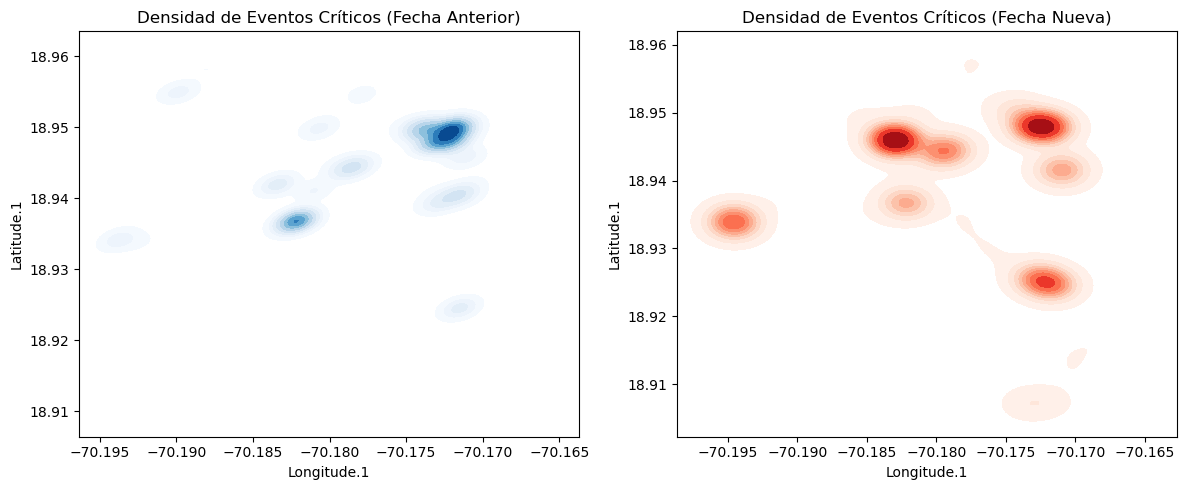

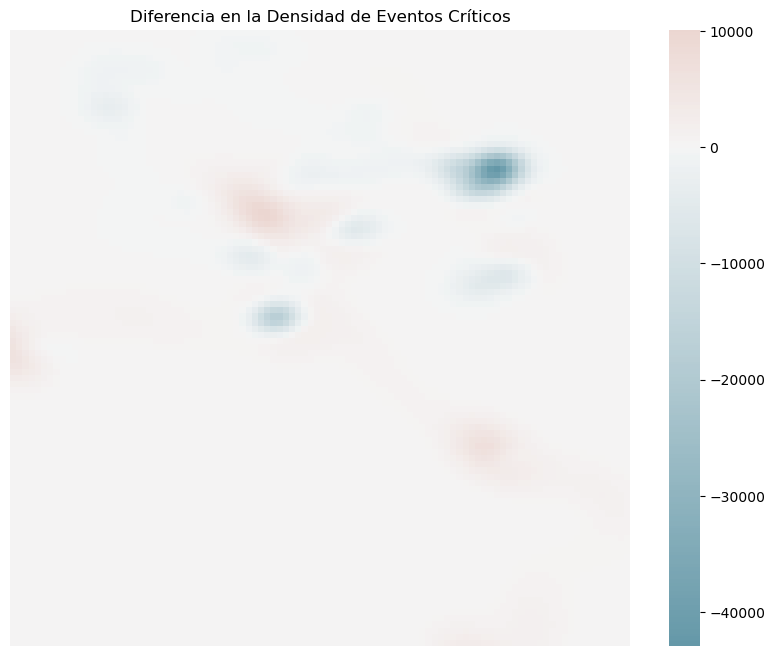

In [11]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import folium
from fpdf import FPDF
import tkinter as tk
from tkinter import filedialog
import io
from PIL import Image
from bokeh.tile_providers import get_provider, Vendors

def cargar_datos(file_path):
    """Carga un archivo CSV y aplica la identificación de eventos críticos."""
    df = pd.read_csv(file_path, encoding="latin1")
    df = df.dropna(subset=["Longitude.1", "Latitude.1"])  # Eliminar valores nulos
    df["Sharp Turn"] = df["Radius of turn (m)"].apply(lambda x: x < 5)
    df["High Speed"] = df["Speed (km/h)"].apply(lambda x: x > 50)
    df["Critical Event"] = df[["Sharp Turn", "High Speed"]].any(axis=1)
    
    # Convertir a GeoDataFrame en Web Mercator
    puntos = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy(df["Longitude.1"], df["Latitude.1"]),
        crs="epsg:4326"
    ).to_crs(epsg=3857)
    
    return df, puntos

def seleccionar_archivo():
    """Abre un cuadro de diálogo para seleccionar un archivo CSV."""
    file_path = filedialog.askopenfilename(title="Seleccione un archivo CSV", filetypes=[("CSV Files", "*.csv")])
    return file_path

def generar_grafico_distribucion(df_old, df_new):
    """Genera gráficos de distribución de eventos críticos."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.histplot(df_old["Speed (km/h)"], bins=50, kde=True, color="blue", ax=axes[0], alpha=0.6)
    sns.histplot(df_new["Speed (km/h)"], bins=50, kde=True, color="red", ax=axes[1], alpha=0.6)
    axes[0].set_title("Distribución de Velocidades (Fecha Anterior)")
    axes[1].set_title("Distribución de Velocidades (Fecha Nueva)")
    plt.tight_layout()
    
    buffer = io.BytesIO()
    plt.savefig(buffer, format="png")
    buffer.seek(0)
    return buffer

def generar_grafico_densidad(df_old, df_new):
    """Genera gráficos de densidad KDE para los eventos críticos."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.kdeplot(data=df_old[df_old["Critical Event"]], x="Longitude.1", y="Latitude.1", fill=True, cmap="Blues", ax=axes[0])
    sns.kdeplot(data=df_new[df_new["Critical Event"]], x="Longitude.1", y="Latitude.1", fill=True, cmap="Reds", ax=axes[1])
    axes[0].set_title("Densidad de Eventos Críticos (Fecha Anterior)")
    axes[1].set_title("Densidad de Eventos Críticos (Fecha Nueva)")
    plt.tight_layout()
    
    buffer = io.BytesIO()
    plt.savefig(buffer, format="png")
    buffer.seek(0)
    return buffer

def generar_grafico_diferencia(df_old, df_new):
    """Genera un mapa de diferencia de densidad KDE entre ambas fechas."""
    fig, ax = plt.subplots(figsize=(10, 8))
    
    df_old = df_old.dropna(subset=["Longitude.1", "Latitude.1"])
    df_new = df_new.dropna(subset=["Longitude.1", "Latitude.1"])
    
    if len(df_old) > 1 and len(df_new) > 1:
        kde_old = gaussian_kde(np.vstack([df_old["Longitude.1"], df_old["Latitude.1"]]))
        kde_new = gaussian_kde(np.vstack([df_new["Longitude.1"], df_new["Latitude.1"]]))
        
        xmin, xmax = df_old["Longitude.1"].min(), df_old["Longitude.1"].max()
        ymin, ymax = df_old["Latitude.1"].min(), df_old["Latitude.1"].max()
        xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
        positions = np.vstack([xx.ravel(), yy.ravel()])
        
        density_old = kde_old(positions).T.reshape(xx.shape)
        density_new = kde_new(positions).T.reshape(xx.shape)
        density_diff = density_new - density_old
        
        cmap = sns.diverging_palette(220, 20, as_cmap=True)
        sns.heatmap(np.rot90(density_diff), cmap=cmap, center=0, alpha=0.8, cbar=True, xticklabels=False, yticklabels=False, ax=ax)
    
    ax.set_title("Diferencia en la Densidad de Eventos Críticos")
    
    buffer = io.BytesIO()
    plt.savefig(buffer, format="png")
    buffer.seek(0)
    return buffer

def generar_reporte_pdf(grid_change, critical_counts, df_old, df_new, file_path):
    """Genera un informe PDF con el análisis de criticidad y gráficos."""
    pdf = FPDF()
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.add_page()
    pdf.set_font("Arial", "B", 16)
    pdf.cell(200, 10, "Reporte de Comparación de Criticidad en la Mina", ln=True, align="C")
    pdf.ln(10)
    
    pdf.set_font("Arial", "", 12)
    for key, value in critical_counts.items():
        pdf.cell(200, 10, f"{key}: {value}", ln=True)
    pdf.ln(10)
    
    pdf.set_font("Arial", "B", 14)
    pdf.cell(200, 10, "Densidad de Eventos Críticos", ln=True)
    pdf.ln(5)
    density_plot = generar_grafico_densidad(df_old, df_new)
    with open("density_plot.png", "wb") as f:
        f.write(density_plot.getbuffer())
    pdf.image("density_plot.png", x=10, w=180)
    
    pdf.ln(10)
    pdf.cell(200, 10, "Diferencia de Densidad de Eventos Críticos", ln=True)
    pdf.ln(5)
    density_diff_plot = generar_grafico_diferencia(df_old, df_new)
    with open("density_diff.png", "wb") as f:
        f.write(density_diff_plot.getbuffer())
    pdf.image("density_diff.png", x=10, w=180)
    
    pdf.output(file_path)
    return file_path

def ejecutar_comparacion():
    """Interfaz gráfica para seleccionar archivos y ejecutar la comparación de criticidad."""
    root = tk.Tk()
    root.withdraw()
    
    file_old = seleccionar_archivo()
    file_new = seleccionar_archivo()
    
    df_old, puntos_old = cargar_datos(file_old)
    df_new, puntos_new = cargar_datos(file_new)
    
    grid_change = calcular_cambio_criticidad(puntos_old, puntos_new, df_old, df_new)
    
    pdf_path = "reporte_comparacion_criticidad.pdf"
    critical_counts = {
        "Fecha Anterior": df_old["Critical Event"].sum(),
        "Fecha Nueva": df_new["Critical Event"].sum(),
    }
    generar_reporte_pdf(grid_change, critical_counts, df_old, df_new, pdf_path)
    
    print(f"Reporte PDF guardado en: {pdf_path}")


ejecutar_comparacion()